In [2]:
import os

In [3]:
import numpy as np
import h5py
import fitsio
import matplotlib.pyplot as plt

In [4]:
import lib
from lib.const import BANDS, DEEPFIELD_BANDS, TRUTH_BANDS

In [5]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"
os.environ["PATH"] += ":/global/common/software/nersc/pm-2023q2/sw/texlive/2022/bin/x86_64-linux"

In [6]:
shear_step = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
mdet_step = "noshear"
tilename = "DES2349-6205"

In [7]:
shear_args = lib.util.parse_shear_arguments(shear_step)

In [8]:
imsim_catalog = lib.const.IMSIM_CATALOGS[shear_step]

In [9]:
hf_imsim = h5py.File(imsim_catalog)

In [9]:
observed_indices, observed_matched_indices, truth_matched_table = lib.instance.match(
    tilename,
    hf_imsim,
    mdet_step="noshear",
    **shear_args,
)

In [10]:
n_objects = len(observed_indices)

In [11]:
n_unmatched = len(
    np.setdiff1d(
        observed_indices,
        observed_matched_indices,
    )
)
print(f"{n_unmatched}/{n_objects} ({n_unmatched / n_objects * 100 :.2f}%) objects without match")

356/17713 (2.01%) objects without match


In [12]:
_, matched_indices, _ = np.intersect1d(
    observed_indices,
    observed_matched_indices,
    return_indices=True,
)

In [13]:
truth_ids = truth_matched_table["des_id"]

In [14]:
deepfield_ids = lib.deepfield.get_deepfield_ids()

In [15]:
_, truth_indices, deepfield_indices = np.intersect1d(
    truth_ids,
    deepfield_ids,
    return_indices=True,
)

In [16]:
# in truth, not in deepfield
n_unmatched = len(
    np.setdiff1d(
        truth_ids,
        deepfield_ids,
    )
)
print(f"{n_unmatched} objects in truth table but not deepfield table")

401 objects in truth table but not deepfield table


In [17]:
# TODO: do case where we don't use KNN, just truth info

In [18]:
deepfield_table = lib.deepfield.get_deepfield_table()

In [19]:
for band in BANDS:
    np.testing.assert_allclose(
        truth_matched_table[f"mag_{band}"][truth_indices],
        deepfield_table[f"MAG_{band}"][deepfield_indices],
    )

---

In [20]:
knn = lib.deepfield.get_knn(deepfield_table)

In [21]:
_X = np.array(
    [
        truth_matched_table[f"flux_{band}"]
        for band in TRUTH_BANDS
    ]
).T

In [22]:
y = knn.predict(_X)

In [23]:
out_table = {}

out_table["indices"] = observed_indices
    
out_table["photoz"] = np.full(n_objects, np.nan)
out_table["photoz"][matched_indices] = truth_matched_table["photoz"]

for i, band in enumerate(DEEPFIELD_BANDS):
    out_table[f"DEEP:flux_{band}"] = np.full(n_objects, np.nan)
    out_table[f"DEEP:flux_{band}"][matched_indices] = _X[:, i]
    out_table[f"DEEP:flux_err_{band}"] = np.full(n_objects, np.nan)
    out_table[f"DEEP:flux_err_{band}"][matched_indices] = y[:, i]
    
for band in BANDS:
    out_table[f"WIDE:pgauss_flux_{band}"] = np.full(n_objects, np.nan)
    out_table[f"WIDE:pgauss_flux_{band}"][matched_indices] = hf_imsim["mdet"][mdet_step][f"pgauss_band_flux_{band}"][observed_matched_indices]
    out_table[f"WIDE:pgauss_flux_err_{band}"] = np.full(n_objects, np.nan)
    out_table[f"WIDE:pgauss_flux_err_{band}"][matched_indices] = hf_imsim["mdet"][mdet_step][f"pgauss_band_flux_err_{band}"][observed_matched_indices]

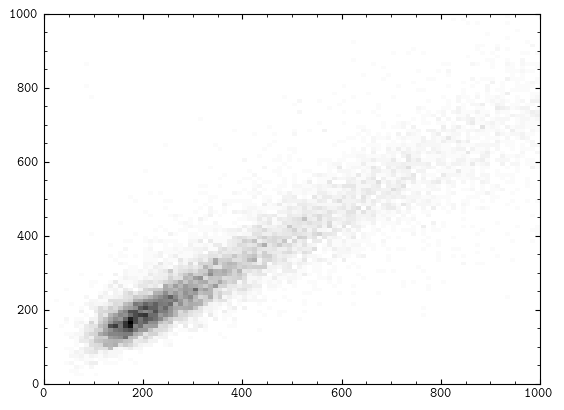

In [24]:
plt.hist2d(
    out_table[f"DEEP:flux_r"],
    out_table[f"WIDE:pgauss_flux_r"],
    bins=[np.linspace(0, 1000, 101), np.linspace(0, 1000, 101)],
)
plt.show()